This notebook shows how to access Sentinel-2 Level-2A data by querying Microsoft's [Planetary Computer Data Catalog](https://planetarycomputer.microsoft.com/catalog). This catalog is served via STAC API and with the datasets hosted on Azure Blob Storage. As we are using open-standards for data-access, the process is largely similar to accessing the data from other STAC API endpoints, with a few minor differences based on how different providers have chosen to pre-process the data.

### Setup and Data Download

The following blocks of code will install the required packages and download the datasets to your Colab environment.

In [ ]:
%%capture
if 'google.colab' in str(get_ipython()):
    !pip install pystac-client odc-stac rioxarray dask jupyter-server-proxy \
      planetary_computer

In [ ]:
import os
import matplotlib.pyplot as plt
import pystac_client
from odc import stac
import planetary_computer as pc
import xarray as xr
import rioxarray as rxr
import pyproj

In [ ]:
from dask.distributed import Client
client = Client()  # set up local cluster on the machine
client

If you are running this notebook in Colab, you will need to create and use a proxy URL to see the dashboard running on the local server.

In [ ]:
if 'google.colab' in str(get_ipython()):
    from google.colab import output
    port_to_expose = 8787  # This is the default port for Dask dashboard
    print(output.eval_js(f'google.colab.kernel.proxyPort({port_to_expose})'))


In [ ]:
data_folder = 'data'
output_folder = 'output'

if not os.path.exists(data_folder):
    os.mkdir(data_folder)
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

### Get Satellite Imagery using STAC API

We define a location and time of interest to get some satellite imagery.

In [ ]:
latitude = 27.163
longitude = 82.608
year = 2023

In [ ]:
# Define a small bounding box around the chosen point
km2deg = 1.0 / 111
x, y = (longitude, latitude)
r = 1 * km2deg  # radius in degrees
bbox = (x - r, y - r, x + r, y + r)

Let's use [Planetary Computer STAC API](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/) search endpoint to look for items from the sentinel-2-l2a collection on Azure Blob Storage.

In [ ]:
catalog = pystac_client.Client.open(
    'https://planetarycomputer.microsoft.com/api/stac/v1')

search = catalog.search(
    collections=['sentinel-2-l2a'],
    bbox=bbox,
    datetime=f'{year}',
    query={'eo:cloud_cover': {'lt': 30}},
)
items = search.item_collection()
items

Load the matching images as a XArray Dataset. Accessing data from Planetary Computer is free but requires getting a Shared Access Signature (SAS) token and sign the URLs. The `planetary_computer` Python package provides a simple mechanism for signing the URLs using `sign()` function.

In [ ]:
# Load to XArray
ds = stac.load(
    items,
    bands=['red', 'green', 'blue', 'nir', 'SCL'],
    bbox=bbox, # <-- load data only for the bbox
    resolution=10,
    chunks={},  # <-- use Dask
    patch_url=pc.sign,
    groupby='solar_day',
    preserve_original_order=True
)
ds

### Processing Data

We have a data cube of multiple scenes collected through the year. As XArray supports vectorized operations, we can work with the entire DataSet the same way we would process a single scene.

The Sentinel-2 scenes come with NoData value of 0. So we set the correct NoData value before further processing.

In [ ]:
# Mask nodata values
ds = ds.where(ds != 0)

Apply scale and offset to all spectral bands

In [ ]:
# Apply scale/offset
scale = 0.0001
offset = -0.1
# Select spectral bands (all except 'scl')
data_bands = [band for band in ds.data_vars if band != 'SCL']
for band in data_bands:
  ds[band] = ds[band] * scale + offset

Apply the cloud mask

In [ ]:
ds = ds[data_bands].where(~ds.SCL.isin([3,8,9,10]))
ds

Calculate NDVI and add it as a data variable.

In [ ]:
red = ds['red']
nir = ds['nir']

ndvi = (nir - red)/(nir + red)
ds['ndvi'] = ndvi
ds

### Extracting Time-Series

We have a dataset with cloud-masked NDVI values at each pixel of each scene. Remember that none of these values are computed yet. Dask has a graph of all the operations that would be required to calculate the results.

We can now query this results for values at our chosen location. Once we run `compute()` - Dask will fetch the required tiles from the source data and run the operations to give us the results.

Our location coordinates are in EPSG:4326 Lat/Lon. Convert it to the CRS of the dataset so we can query it.

In [ ]:
crs = ds.rio.crs
transformer = pyproj.Transformer.from_crs('EPSG:4326', crs, always_xy=True)
x, y = transformer.transform(longitude, latitude)
x,y

Query NDVI values at the coordinates.

In [ ]:
time_series = ds.ndvi \
  .interp(y=y, x=x, method='nearest')

Run the calculation and load the results into memory.

In [ ]:
%%time
time_series = time_series.compute()

Plot the time-series.

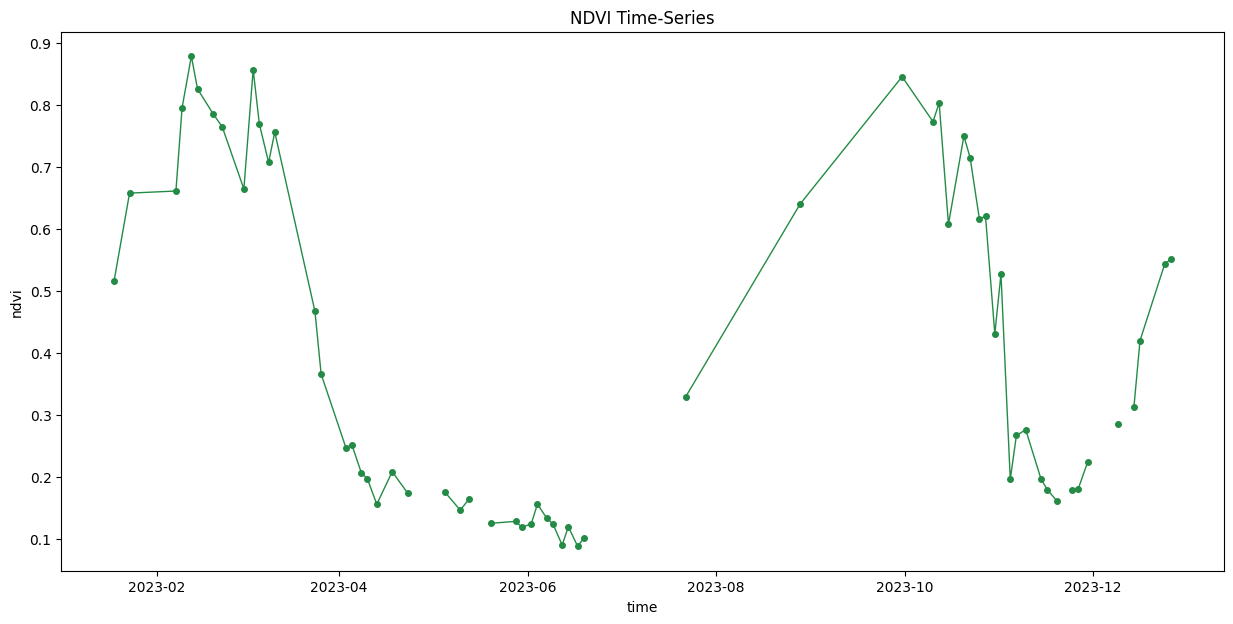

In [ ]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15, 7)

time_series.plot.line(
    ax=ax, x='time',
    marker='o', color='#238b45',
    linestyle='-', linewidth=1, markersize=4)

# Format the x-axis to display dates as YYYY-MM
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))

ax.set_title('NDVI Time-Series')
plt.show()

### Interpolate and Smooth the time-series

We use XArray's excellent time-series processing functionality to smooth the time-series and remove noise.

In [ ]:
# As we are proceesing the time-series,
# it needs to be in a single chunk along the time dimension
time_series = time_series.chunk(dict(time=-1))

First, we resample the time-series to have a value every 5-days and fill the missing values with linear interpolation. Then we apply a moving-window smoothing to remove noise.

In [ ]:
time_series_resampled = time_series\
  .resample(time='5d').mean(dim='time').chunk(dict(time=-1))
time_series_interpolated = time_series_resampled \
  .interpolate_na('time', use_coordinate=False)
time_series_smoothed = time_series_interpolated \
  .rolling(time=3, min_periods=1, center=True).mean()

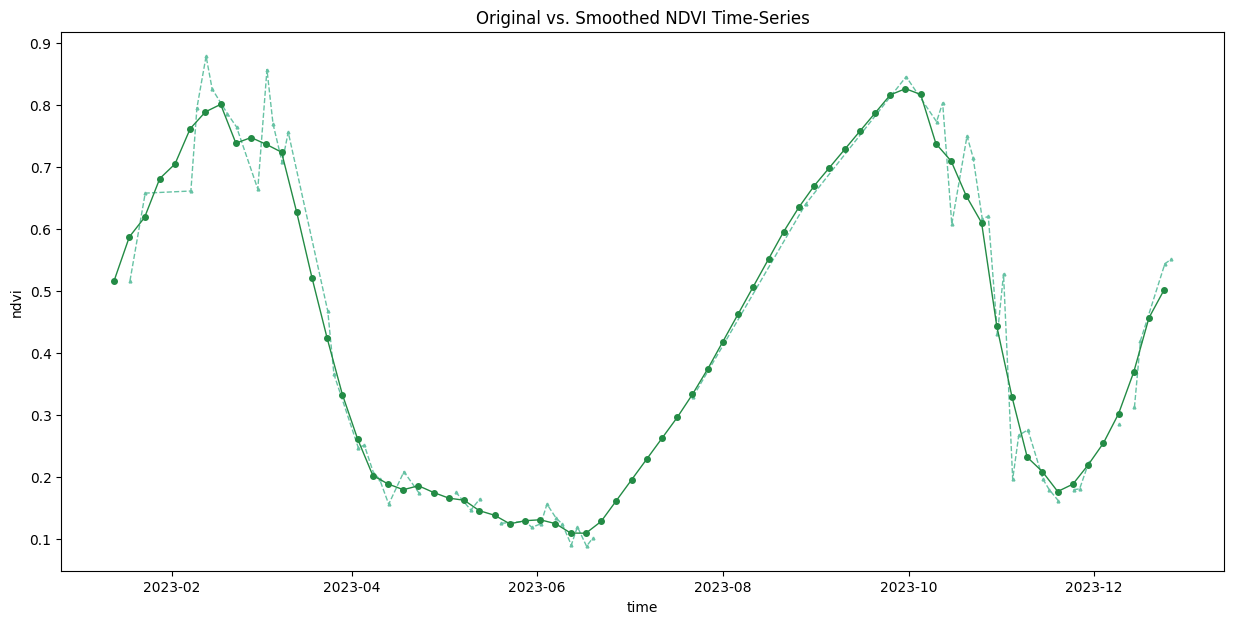

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15, 7)
time_series.plot.line(
    ax=ax, x='time',
    marker='^', color='#66c2a4',
    linestyle='--', linewidth=1, markersize=2)
time_series_smoothed.plot.line(
    ax=ax, x='time',
    marker='o', color='#238b45',
    linestyle='-', linewidth=1, markersize=4)

# Format the x-axis to display dates as YYYY-MM
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))

ax.set_title('Original vs. Smoothed NDVI Time-Series')

plt.show()


### Save the Time-Series.

Convert the extracted time-series to a Pandas DataFrame.


In [ ]:
df = time_series_smoothed.to_pandas().reset_index()
df.head()


Save the DataFrame as a CSV file.

In [ ]:
output_filename = 'ndvi_time_series.csv'
output_filepath = os.path.join(output_folder, output_filename)
df.to_csv(output_filepath, index=False)